In [1]:
import numpy as np
import pandas as pd
#import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, RNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [2]:
# Đọc dữ liệu từ file CSV (có thể thay bằng file của bạn)
data = pd.read_csv('D:\DeTaiNam2024\SoLieuHong\HNX.csv')
# Kiểm tra tiêu đề các cột
data.head()

,Unnamed: 0,time,open,high,low,close,volume
0,0,24/8/2017,184.41,188.04,184.35,188.04,18579100
1,1,25/8/2017,188.03,189.23,187.57,188.17,18386500
2,2,28/8/2017,189.37,190.66,187.73,190.30,19843100
3,3,29/8/2017,189.10,191.51,189.05,190.28,18307100
4,4,30/8/2017,190.68,192.53,189.59,189.78,15084300


In [3]:
 data = data[['close']]
 data.dropna(inplace=True)

In [4]:
# Chuẩn bị dữ liệu
def prepare_data(data, time_steps=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    X, y = [], []
    for i in range(time_steps, len(scaled_data)):
        X.append(scaled_data[i-time_steps:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)

    # Reshape X để phù hợp với RNN [samples, time_steps, features]
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, scaler


In [5]:
X, y, scaler = prepare_data(data)

In [6]:
X

array([[[0.02853582],
        [0.02871992],
        [0.03173637],
        ...,
        [0.04731423],
        [0.04829139],
        [0.05004744]],

       [[0.02871992],
        [0.03173637],
        [0.03170804],
        ...,
        [0.04829139],
        [0.05004744],
        [0.05034484]],

       [[0.03173637],
        [0.03170804],
        [0.03099996],
        ...,
        [0.05004744],
        [0.05034484],
        [0.05020322]],

       ...,

       [[0.51248354],
        [0.51530171],
        [0.51120898],
        ...,
        [0.52772152],
        [0.52445017],
        [0.52966168]],

       [[0.51530171],
        [0.51120898],
        [0.51683118],
        ...,
        [0.52445017],
        [0.52966168],
        [0.52670188]],

       [[0.51120898],
        [0.51683118],
        [0.52086726],
        ...,
        [0.52966168],
        [0.52670188],
        [0.52479005]]])

In [7]:
class sLSTMCell(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(sLSTMCell, self).__init__(**kwargs)
        self.units = units
        self.state_size = [self.units, self.units]  # [hidden_state, normalizer_state]

    def build(self, input_shape):
        # Khởi tạo trọng số cho các cổng
        self.W_f = self.add_weight(shape=(input_shape[-1], self.units),
                                   initializer='glorot_uniform',
                                   name='W_f')
        self.U_f = self.add_weight(shape=(self.units, self.units),
                                   initializer='orthogonal',
                                   name='U_f')
        self.b_f = self.add_weight(shape=(self.units,),
                                   initializer='zeros',
                                   name='b_f')

        self.W_i = self.add_weight(shape=(input_shape[-1], self.units),
                                   initializer='glorot_uniform',
                                   name='W_i')
        self.U_i = self.add_weight(shape=(self.units, self.units),
                                   initializer='orthogonal',
                                   name='U_i')
        self.b_i = self.add_weight(shape=(self.units,),
                                   initializer='zeros',
                                   name='b_i')

        self.W_c = self.add_weight(shape=(input_shape[-1], self.units),
                                   initializer='glorot_uniform',
                                   name='W_c')
        self.U_c = self.add_weight(shape=(self.units, self.units),
                                   initializer='orthogonal',
                                   name='U_c')
        self.b_c = self.add_weight(shape=(self.units,),
                                   initializer='zeros',
                                   name='b_c')

        self.W_o = self.add_weight(shape=(input_shape[-1], self.units),
                                   initializer='glorot_uniform',
                                   name='W_o')
        self.U_o = self.add_weight(shape=(self.units, self.units),
                                   initializer='orthogonal',
                                   name='U_o')
        self.b_o = self.add_weight(shape=(self.units,),
                                   initializer='zeros',
                                   name='b_o')
        super(sLSTMCell, self).build(input_shape)

    def call(self, inputs, states):
        h_prev, n_prev = states

        # Forget gate: sử dụng sigmoid hoặc exp
       # f = tf.keras.activations.sigmoid(tf.matmul(inputs, self.W_f) + tf.matmul(h_prev, self.U_f) + self.b_f)
        f = tf.exp(tf.matmul(inputs, self.W_f) + tf.matmul(h_prev, self.U_f) + self.b_f)

        # Input gate: sử dụng (sigmoid)^2 hoặc (exp)^2
      #  i = tf.keras.activations.sigmoid(tf.matmul(inputs, self.W_i) + tf.matmul(h_prev, self.U_i) + self.b_i)
       # i = tf.square(i)  # (σ(x))^2
        i = tf.exp(tf.matmul(inputs, self.W_i) + tf.matmul(h_prev, self.U_i) + self.b_i)
        # Candidate cell state
        c_tilde = tf.keras.activations.tanh(tf.matmul(inputs, self.W_c) + tf.matmul(h_prev, self.U_c) + self.b_c)

        # Cell state update
        c = f * states[0] + i * c_tilde

        # Normalizer state update
        n = f * n_prev + i

        # Output gate
        o = tf.keras.activations.sigmoid(tf.matmul(inputs, self.W_o) + tf.matmul(h_prev, self.U_o) + self.b_o)

        # Normalized hidden state
        h_tilde = c * tf.math.reciprocal(n + 1e-7)  # thêm epsilon để tránh chia cho 0
        h = o * h_tilde

        return h, [h, n]

class sLSTM(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(sLSTM, self).__init__(**kwargs)
        self.units = units
        self.cell = sLSTMCell(units)

    def call(self, inputs):
        return tf.keras.layers.RNN(self.cell, return_sequences=False, return_state=False)(inputs)

    def get_config(self):
        config = super(sLSTM, self).get_config()
        config.update({'units': self.units})
        return config


In [8]:
# Xây dựng mô hình
def build_model(time_steps, units=50):
    inputs = Input(shape=(time_steps, 1))
    x = sLSTM(units)(inputs)
    x = Dense(1)(x)
    model = Model(inputs, x)
    model.compile(optimizer=Adam(learning_rate=2e-02), loss='mean_squared_error')
    return model
# Khởi tạo mô hình
model = build_model(time_steps=60, units=50)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 s_lstm (sLSTM)              (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [9]:

# Chia dữ liệu thành tập huấn luyện và kiểm tra
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Xây dựng mô hình
model = build_model(time_steps=60, units=50)

# Huấn luyện mô hình
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop])


Epoch 1/100
47/47 [==============================] - 6s 53ms/step - loss: 0.0266 - val_loss: 3.0203e-04
Epoch 2/100
47/47 [==============================] - 2s 40ms/step - loss: 4.9964e-04 - val_loss: 4.5787e-04
Epoch 3/100
47/47 [==============================] - 2s 36ms/step - loss: 3.0963e-04 - val_loss: 4.1034e-04
Epoch 4/100
47/47 [==============================] - 2s 39ms/step - loss: 2.6217e-04 - val_loss: 2.0420e-04
Epoch 5/100
47/47 [==============================] - 2s 43ms/step - loss: 2.7282e-04 - val_loss: 1.9262e-04
Epoch 6/100
47/47 [==============================] - 2s 45ms/step - loss: 2.4549e-04 - val_loss: 1.8572e-04
Epoch 7/100
47/47 [==============================] - 2s 42ms/step - loss: 2.2003e-04 - val_loss: 2.5377e-04
Epoch 8/100
47/47 [==============================] - 2s 42ms/step - loss: 2.0924e-04 - val_loss: 1.7243e-04
Epoch 9/100
47/47 [==============================] - 2s 43ms/step - loss: 2.2599e-04 - val_loss: 1.8298e-04
Epoch 10/100
47/47 [============

6/6 [==============================] - 0s 8ms/step
Root Mean Squared Error (RMSE): 8.70410316031505
Mean Squared Error (MSE): 75.76141182540643


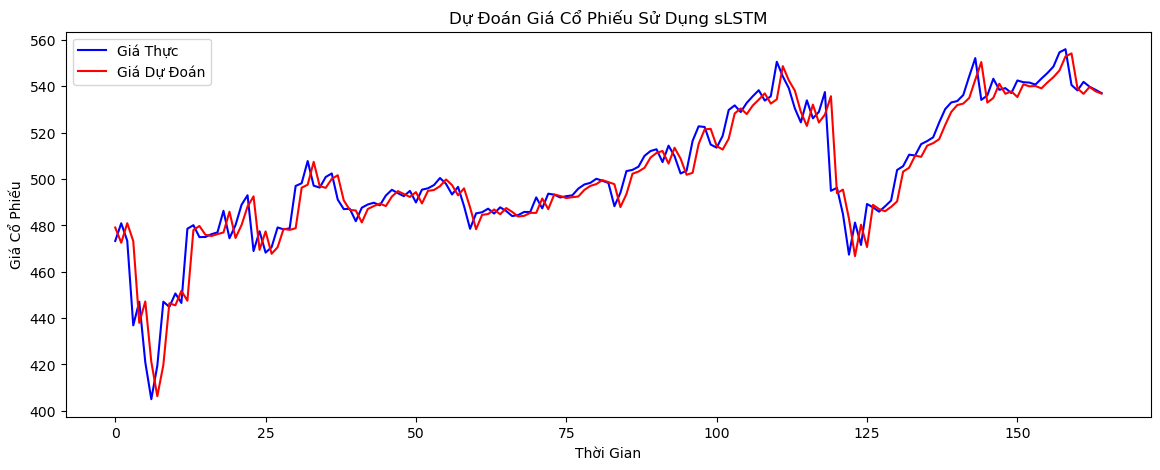

In [10]:

# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)

# Đảo chuẩn hóa để lấy giá trị thực
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Tính toán RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f'Root Mean Squared Error (RMSE): {rmse}')
mse = mean_squared_error(y_test_inv, y_pred_inv)
print(f'Mean Squared Error (MSE): {mse}')
# Vẽ đồ thị so sánh giá thực và giá dự đoán
plt.figure(figsize=(14, 5))
plt.plot(y_test_inv, color='blue', label='Giá Thực')
plt.plot(y_pred_inv, color='red', label='Giá Dự Đoán')
plt.title('Dự Đoán Giá Cổ Phiếu Sử Dụng sLSTM')
plt.xlabel('Thời Gian')
plt.ylabel('Giá Cổ Phiếu')
plt.legend()
plt.show()


In [11]:
mse1=np.mean(np.square(y_pred_inv - y_test_inv))
print('MSE=', mse1)
mean_error_percent1 = np.mean(np.abs((y_pred_inv - y_test_inv) / y_test_inv))
accuracy1 = 1 - mean_error_percent1
print('Accuracy=', accuracy1)
print('mean_error_percent=', mean_error_percent1)

MSE= 75.76141182540643
Accuracy= 0.9881183131399073
mean_error_percent= 0.011881686860092751
